In [1]:
import numpy as np
import pandas as pd
import json
import random

n = 15
customer = [i for i in range(1, n + 1)]
node = [0] + customer
arcos = [(i,j) for i in node for j in node if i != j]
f = open('pelanggan.json')
data = json.load(f)
# get customer demand and location data
df = pd.DataFrame(data)
# print(df)
# get distance data
distance = np.loadtxt('distance.txt')
vehicle_capacity = 250
demand = df.demand

In [55]:
default = 0.5
Q = np.zeros((len(node),len(node)))
for i in range(len(node)):
    for j in range(len(node)):
        if(i!=j):
            Q[i][j] = default
DA = np.array([0])
np.savetxt('Q.txt', Q)
np.savetxt('DA.txt',DA)

In [56]:
miu = 0.05
diskon = 0.9
epsilon = 0.01

def bestq(qtable, node, i):
    curr_qtable = qtable[i]
    curr_qtable = np.copy(curr_qtable[node, ])
    max_value = np.max(curr_qtable)
    result = np.where(curr_qtable == max_value)[0]
    if(len(result) == 1):
        return node[result[0]]
    else:
        rnd = random.randint(0,len(result)-1)
        return node[result[rnd]]

def randomq(node):
    result = random.randint(0,len(node)-1)
    return node[result]

def maxq(qtable, node, i):
    curr_qtable = qtable[i]
    curr_qtable = np.copy(curr_qtable[node, ])
    max_value = np.max(curr_qtable)
    return max_value

def minq(qtable, node, i):
    curr_qtable = qtable[i]
    curr_qtable = np.copy(curr_qtable[node, ])
    min_value = np.min(curr_qtable)
    return min_value

def countDistance(route):
    total = 0
    for n in range(len(route)):
        total+=distance[route[n][0]][route[n][1]]
    return total

def updateQ(Q, croute, nodes, total):
    DA = np.loadtxt('DA.txt')
    # r = 1
    #Fungsi untuk Rewrard
    if DA == 0:
        DA = total
        DAnew = total
    else: 
        DAnew = (DA + total)/2
    if(DA>total):
        rn = 1
    else:
        rn = 0
    #End Fungsi untuk Reward
    Qnew = np.copy(Q)
    for k in range(len(croute)):
        route = croute[k]
        node = nodes[k]
        for n in range(len(route) - 1):
            i = route[n][0]
            j = route[n][1]
            if(n == len(route) - 1 ):
                r = rn
            else:
                r = 0
            Qnew[i][j] = Q[i][j] + ( miu * ( r + ( diskon * maxq(Q,node[n],j) ) - Q[i][j] ) )
    np.savetxt('Q.txt', Qnew)  
    np.savetxt('DA.txt', np.array([DAnew]))

def updateQ2(Q, croute, nodes, total):
    DA = np.loadtxt('DA.txt')
    # r = 1
    #Fungsi untuk Rewrard
    if DA == 0:
        DA = total
        
    if(DA>total):
        rn = 1
        DA = total
    else:
        rn = 0
    #End Fungsi untuk Reward
    Qnew = np.copy(Q)
    for k in range(len(croute)):
        route = croute[k]
        node = nodes[k]
        for n in range(len(route) - 1):
            i = route[n][0]
            j = route[n][1]
            if(n == len(route) - 1 ):
                r = rn
            else:
                r = 0
            Qnew[i][j] = Q[i][j] + ( miu * ( r + ( diskon * maxq(Q,node[n],j) ) - Q[i][j] ) )
    np.savetxt('Q.txt', Qnew)  
    np.savetxt('DA.txt', np.array([DA]))

def updateQ3(Q, croute, nodes, total):
    DA = np.loadtxt('DA.txt')
    # r = 1
    #Fungsi untuk Rewrard
    if DA == 0:
        DA = total
        
    if(DA>=total):
        r = 1
        DA = total
    else:
        r = 0
    #End Fungsi untuk Reward
    print(r)
    Qnew = np.copy(Q)
    for k in range(len(croute)):
        route = croute[k]
#         print(route)
        node = nodes[k]
        for n in range(len(route) - 1):
            i = route[n][0]
            j = route[n][1]
            Qnew[i][j] = Q[i][j] + ( miu * ( r + ( diskon * maxq(Q,node[n],j) ) - Q[i][j] ) )
#             print(Q[i][j])
#             print( r + ( diskon * maxq(Q,node[n],j) ) - Q[i][j])
#             print(Qnew[i][j])
    np.savetxt('Q.txt', Qnew)  
    np.savetxt('DA.txt', np.array([DA]))


In [64]:
MaxEpisode = 10
episode = 0
cek1 = []
cek2 = []
best_route=[]
best_distance=0

while(episode < MaxEpisode):
    Q = np.loadtxt('Q.txt')
    nodes = np.array(node)
    nodes = np.delete(nodes, [0])
    capacity = vehicle_capacity
    route = 1
    routes = []
    rnode = []
    croute = []
    crnode = []
    i = 0
    total_dis = 0
    while(len(nodes)>0):
        greed = random.random()
        if(len(nodes) == 1):
            j = nodes[0]
            if (capacity - demand[j]) < 0 :
                routes.append([i,0])
                rnode.append(  np.insert(np.copy(nodes), 0, 0) )
                croute.append(routes)
                crnode.append(rnode)
                #
                total_dis+=countDistance(routes)
                #
                i = 0
                routes = []
                rnode = []
                route += 1                
            routes.append([i,j])
            routes.append([j,0]) 
            rnode.append(  np.insert(np.copy(nodes), 0, 0) )
            croute.append(routes)
            crnode.append(rnode)
            #
            total_dis+=countDistance(routes)
            #
            i = 0
            routes = []
            rnode = []
            route += 1  
            break
        if greed < epsilon :
            #Exploration Move
            j = randomq(nodes)
        else:
            #Exploitation Move
            j = bestq(Q, nodes, i)
        if (capacity - demand[j]) > 0 :
            routes.append([i,j])
            rnode.append( np.insert(np.copy(nodes), 0, 0) )
            getndex = np.where(nodes == j)[0]
            nodes = np.delete(nodes, [getndex])
            capacity -= demand[j]
            i = j
        else:
            routes.append([i,0])
            rnode.append( np.insert(np.copy(nodes), 0, 0) )
            croute.append(routes)
            crnode.append(rnode)
            #
            total_dis+=countDistance(routes)
            #
            i = 0
            routes = []
            rnode = []
            route += 1
            capacity = vehicle_capacity

    print("Episode : "+str(episode))
    updateQ3(Q, croute, crnode,total_dis)
    cek1.append(episode)
    cek2.append(total_dis)
    for n in range(route - 1):
        print("Rute "+str(n)+" : "+str(croute[n]))
    episode += 1
    print("Total Distace : "+str(total_dis))
    print("-------------------------")    
    if ( best_distance == 0) or (best_distance>total_dis) :
        best_distance = total_dis
        best_route = croute

print("") 
print("") 
print("----------BEST ROUTE---------------") 
for n in range(len(best_route)):
    print("Rute "+str(n)+" : "+str(best_route[n]))
print("Total Distace : "+str(best_distance))


Episode : 0
1
Rute 0 : [[0, 4], [4, 14], [14, 3], [3, 5], [5, 13], [13, 7], [7, 15], [15, 12], [12, 11], [11, 0]]
Rute 1 : [[0, 6], [6, 8], [8, 1], [1, 2], [2, 9], [9, 0]]
Rute 2 : [[0, 10], [10, 0]]
Total Distace : 34631.0
-------------------------
Episode : 1
0
Rute 0 : [[0, 4], [4, 14], [14, 3], [3, 5], [5, 13], [13, 7], [7, 15], [15, 12], [12, 11], [11, 0]]
Rute 1 : [[0, 6], [6, 8], [8, 1], [1, 9], [9, 0]]
Rute 2 : [[0, 10], [10, 2], [2, 0]]
Total Distace : 34866.0
-------------------------
Episode : 2
1
Rute 0 : [[0, 4], [4, 14], [14, 3], [3, 5], [5, 13], [13, 7], [7, 15], [15, 12], [12, 11], [11, 0]]
Rute 1 : [[0, 6], [6, 8], [8, 1], [1, 2], [2, 9], [9, 0]]
Rute 2 : [[0, 10], [10, 0]]
Total Distace : 34631.0
-------------------------
Episode : 3
1
Rute 0 : [[0, 4], [4, 14], [14, 3], [3, 5], [5, 13], [13, 7], [7, 15], [15, 12], [12, 11], [11, 0]]
Rute 1 : [[0, 6], [6, 8], [8, 1], [1, 2], [2, 9], [9, 0]]
Rute 2 : [[0, 10], [10, 0]]
Total Distace : 34631.0
-------------------------


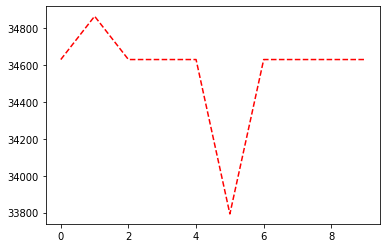

In [66]:
import matplotlib.pyplot as plt
plt.plot(cek1, cek2, 'r--')
plt.show()

In [67]:
Q = np.loadtxt('Q.txt')
Q

array([[0.        , 0.49072531, 0.49856795, 0.58812802, 3.40366828,
        0.59434482, 2.98442601, 0.5       , 0.58464643, 0.53578873,
        1.17044127, 0.50332525, 0.49910992, 0.60458687, 0.495125  ,
        0.51689799],
       [0.5       , 0.        , 1.96642468, 0.54079228, 0.5       ,
        0.5       , 0.5       , 0.50196198, 0.5       , 0.5001825 ,
        0.4975    , 0.50429529, 0.58654209, 0.5       , 0.5       ,
        0.5       ],
       [0.5       , 0.49002076, 0.        , 0.5       , 0.5       ,
        0.5       , 0.5       , 0.495125  , 0.5847207 , 1.24168862,
        0.495125  , 0.5       , 0.5       , 0.5       , 0.4975    ,
        0.4975    ],
       [0.5       , 0.5       , 0.5       , 0.        , 0.5       ,
        3.21892503, 0.5       , 0.5       , 0.5       , 0.5       ,
        0.49839079, 0.5       , 0.5       , 0.5       , 0.5475    ,
        0.5       ],
       [0.5       , 0.5       , 0.5       , 0.51554177, 0.        ,
        0.5       , 0.5       , 

In [7]:
distance[0]

array([    0.,  2724.,  2588.,  3262.,  3705.,  4575.,  2474.,  3532.,
        3287.,  2700.,  1393.,  1760.,  2462.,  2755.,  4179.,  4147.,
        3574.,  3435.,  3555.,  3810.,  4335.,   587.,  1860.,  2232.,
        2953.,  3105.,  1597.,  8713.,  9035.,  9854., 10331.,  6660.,
        6766.,  5268.,  4671.,  4169.,  5850.,  4711.,  4991.,  4771.,
        3741., 13308., 12804.,  4326.,  3899.,  3860.,  4857.,  5221.,
        3882.,  3763.,  3617.])